<a href="https://colab.research.google.com/github/prateeksharma10jan-byte/gen-ai/blob/main/image_denoise_by_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


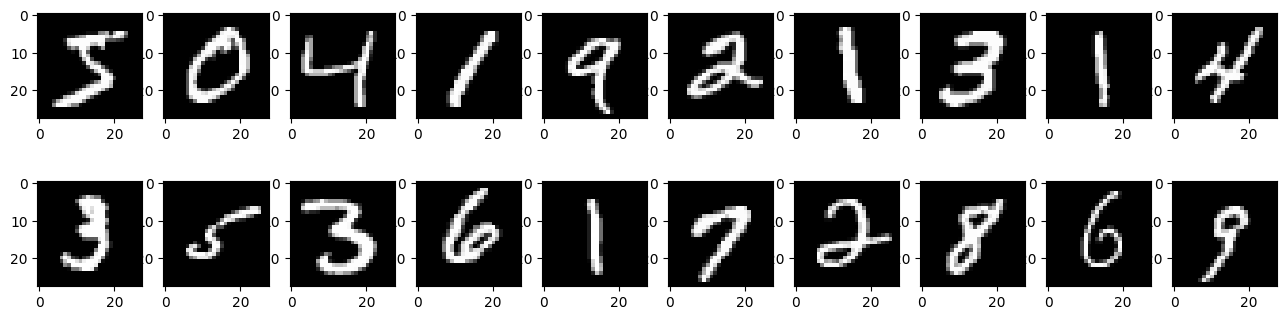

In [ ]:
# import libs
import numpy as np
from keras.datasets import mnist
(X_train , _) ,(X_test, _) = mnist.load_data()
#X_train.shape
#(60000, 28, 28)
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train[count], cmap = 'gray')
        count+=1


In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# prepare source data
noise_factor = 0.1

X_train_noise = X_train + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_test.shape)
X_train.shape

(60000, 28, 28)

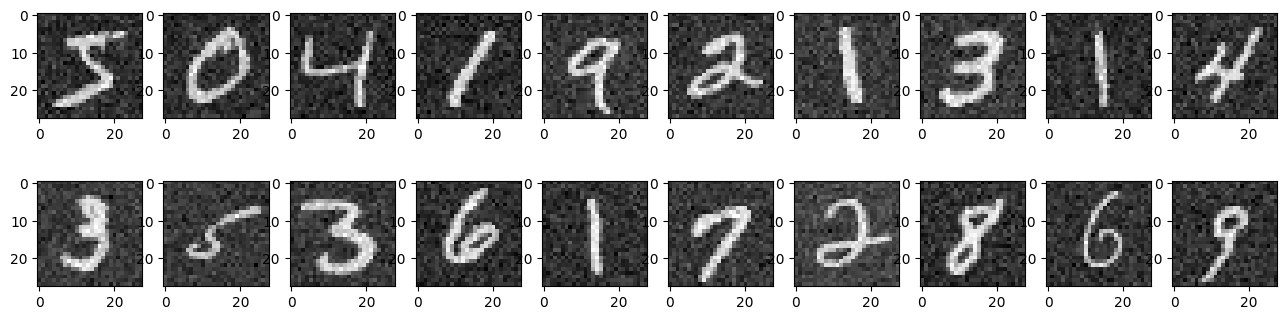

In [ ]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train_noise[count], cmap = 'gray')
        count+=1

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28 ,28, 1)
X_test = X_test.reshape(X_test.shape[0], 28,28,1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28 ,28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28,28,1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
#devices = tf.config.experimental.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(devices[0], enable = True)

In [ ]:
# encoder
encoder_input = Input(shape = X_train.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
#x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
#x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
# decoder
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
#x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
#x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
autoencoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 5, validation_split = 0.25)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8046 - loss: 0.2312 - val_accuracy: 0.8152 - val_loss: 0.0834
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8145 - loss: 0.0805 - val_accuracy: 0.8156 - val_loss: 0.0775
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8150 - loss: 0.0762 - val_accuracy: 0.8157 - val_loss: 0.0754
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8151 - loss: 0.0742 - val_accuracy: 0.8157 - val_loss: 0.0743
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8152 - loss: 0.0731 - val_accuracy: 0.8158 - val_loss: 0.0731


In [ ]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], cmap = 'gray')
            count+=1

In [ ]:
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


(20, 28, 28, 1)

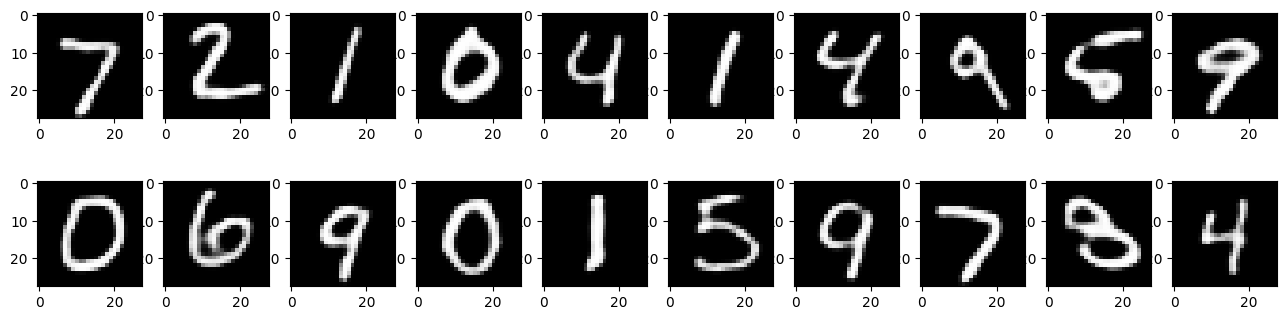

In [ ]:
visualize_data(pred, 2, 10)